In [2]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

ModuleNotFoundError: No module named 'tensorflow'

# task: classify vegetables

* This dataset was used for task: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
* A total of 21000 images from 15 classes are used where each class contains 1400 images of size 224×224 and in *.jpg format. The dataset split 70% for training, 15% for validation, and 15% for testing purpose.

# define data generator

In [5]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=True
)

# search for training data

In [24]:
train_dir = "./data/train"
IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size = 32

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 15000 images belonging to 15 classes.


# found classes

In [25]:
print(train_data_gen.class_indices)

{'Bean': 0, 'Bitter_Gourd': 1, 'Bottle_Gourd': 2, 'Brinjal': 3, 'Broccoli': 4, 'Cabbage': 5, 'Capsicum': 6, 'Carrot': 7, 'Cauliflower': 8, 'Cucumber': 9, 'Papaya': 10, 'Potato': 11, 'Pumpkin': 12, 'Radish': 13, 'Tomato': 14}


# display samples from training set
note: data set is not cleaned at all

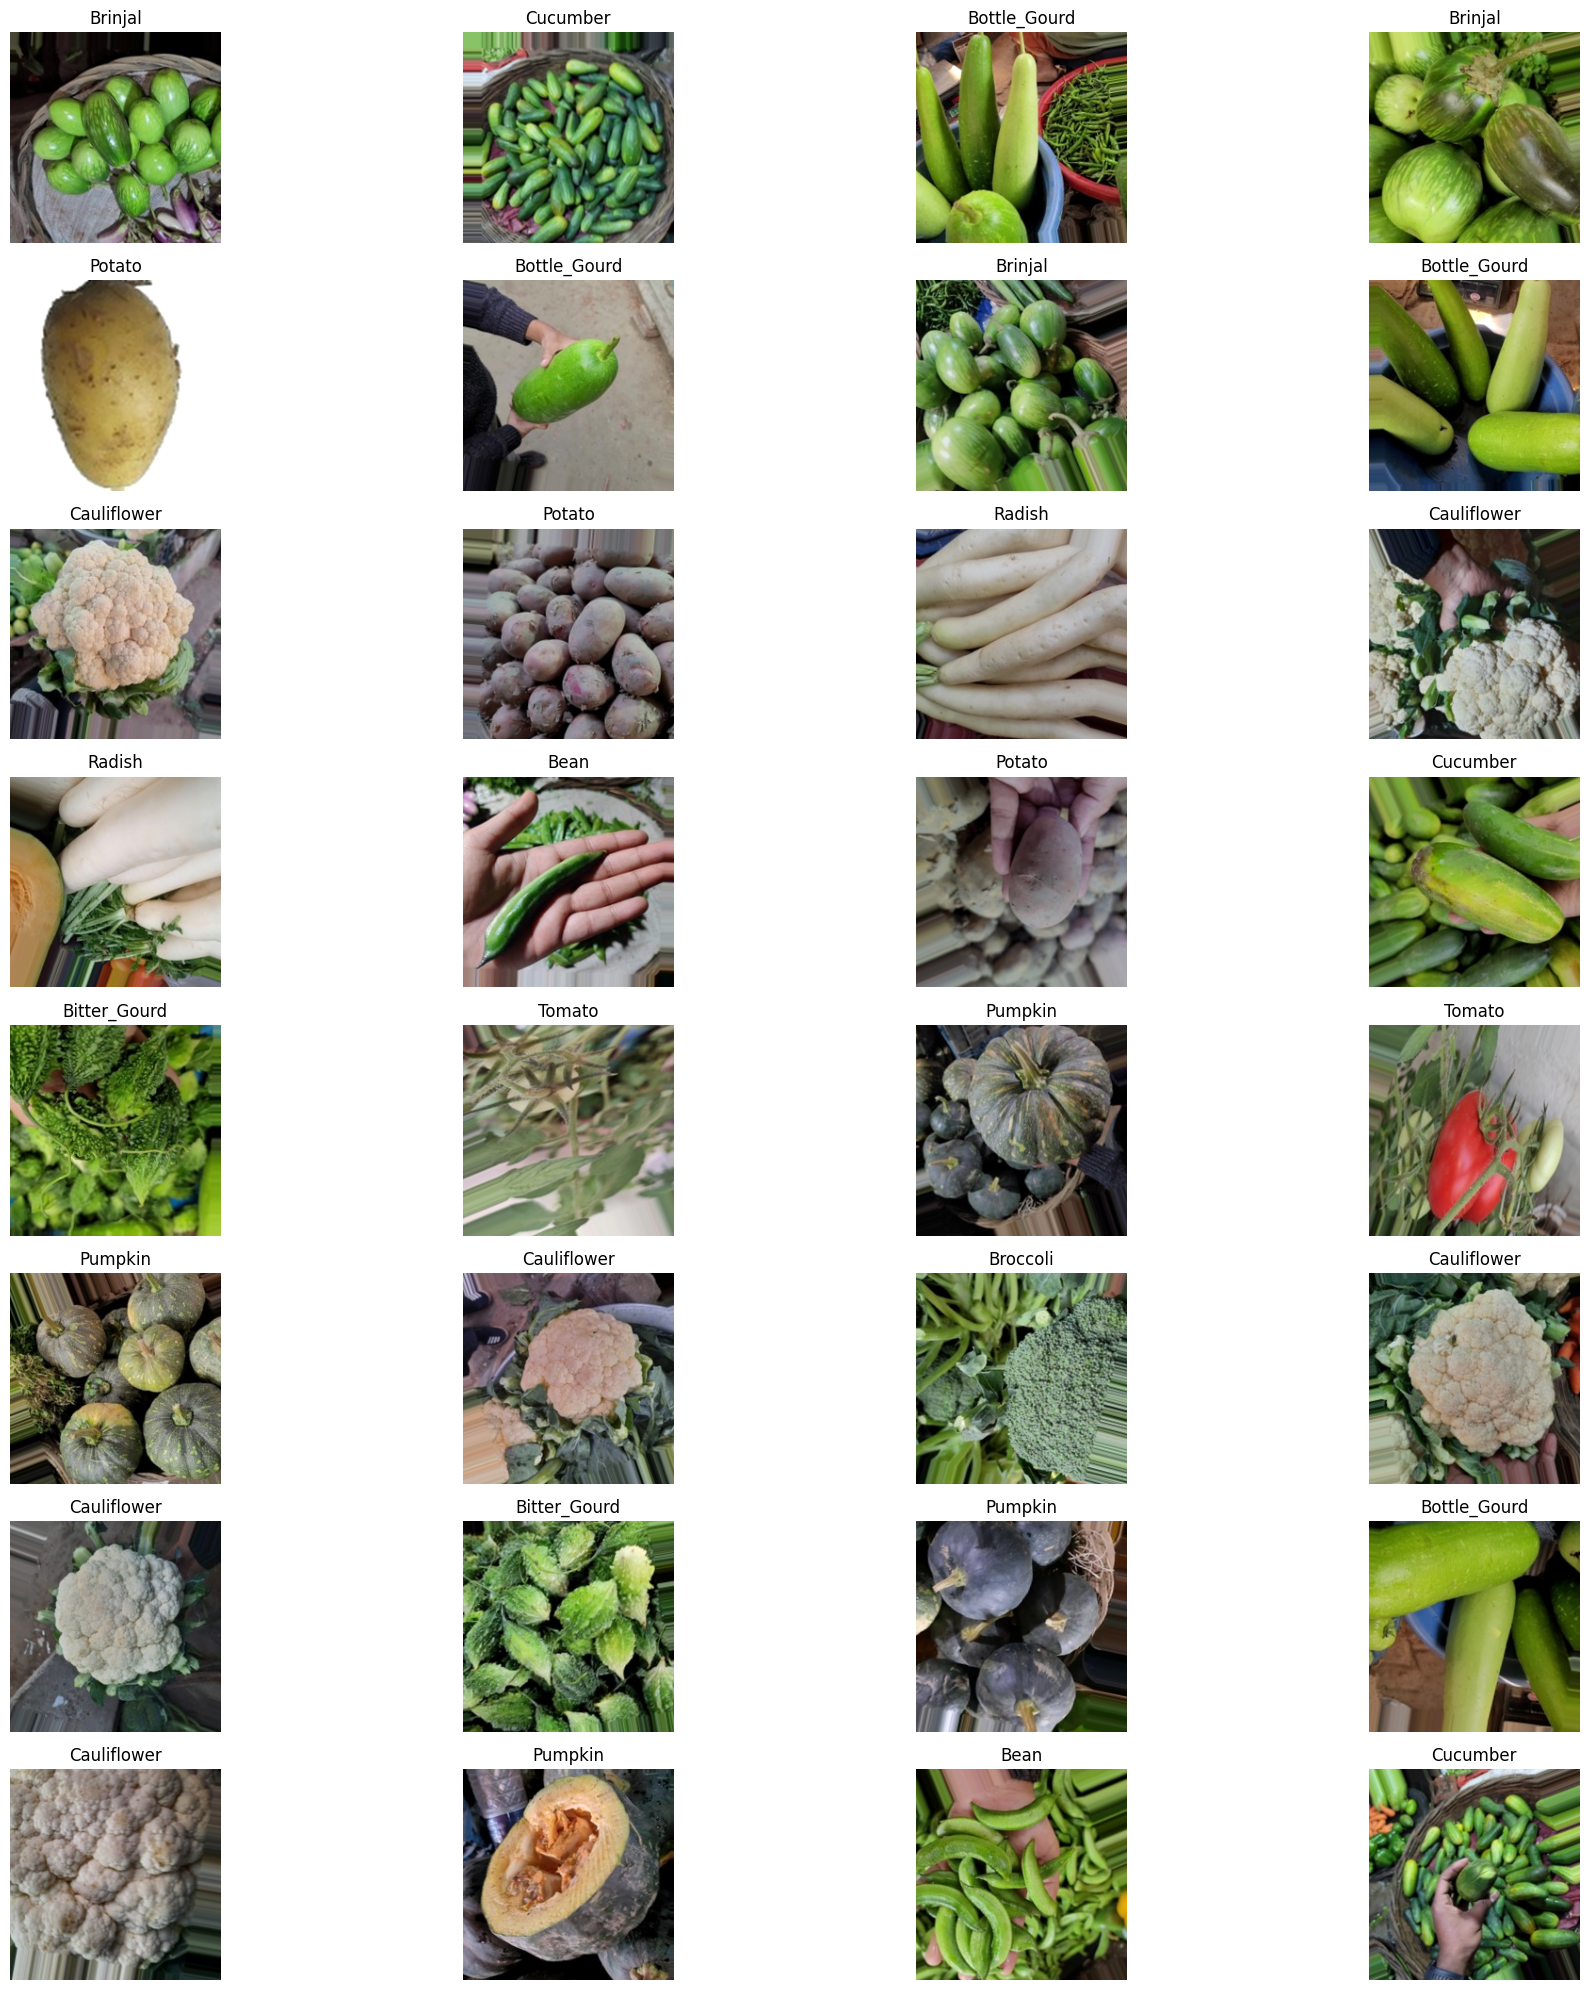

In [8]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# use pre-trained model

In [26]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(
        include_top=False,
        pooling='max',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        weights='imagenet')

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])
    
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ ?                      │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

### utility function that will skip batches if there is a broken image in it

In [27]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            pass

### snapshot callback

# train only the fully connected layers

In [31]:
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

history = model.fit(
    skip_broken_images(train_data_gen),
    steps_per_epoch=2, #use way more steps here: number of samples / batch size
    epochs=20, #use way more or use EarlyStopping callback
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 573ms/step - categorical_accuracy: 0.8229 - loss: 0.9986
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step - categorical_accuracy: 0.7083 - loss: 2.0718
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step - categorical_accuracy: 0.7812 - loss: 1.9766
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step - categorical_accuracy: 0.6562 - loss: 1.3186
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step - categorical_accuracy: 0.8542 - loss: 0.6934
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step - categorical_accuracy: 0.7917 - loss: 0.7214
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step - categorical_accuracy: 0.8854 - loss: 0.4509
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step - categorical_accuracy: 0.8021 - loss: 0.8242
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step - categorical_accuracy: 0.8646 - loss: 0.6090
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step - categorical_accuracy: 0.7396 - loss: 1.3119
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s

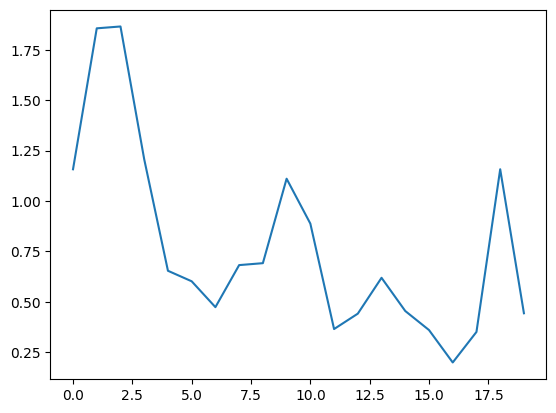

In [32]:
plt.plot(history.history['loss'])

# train complete network

In [35]:
for layer in base_model.layers:
    layer.trainable = True
    
    
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])    

history = model.fit(
    skip_broken_images(train_data_gen),
    steps_per_epoch=5, #use way more steps here: number of samples / batch size
    epochs=15, #use way more or use EarlyStopping callback
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - categorical_accuracy: 0.3484 - loss: 2.0396
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - categorical_accuracy: 0.2626 - loss: 2.2166
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - categorical_accuracy: 0.3276 - loss: 1.9527
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - categorical_accuracy: 0.3080 - loss: 2.0839
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - categorical_accuracy: 0.3354 - loss: 1.9898
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - categorical_accuracy: 0.3009 - loss: 2.2321
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - categorical_accuracy: 0.2802 - loss: 2.2529
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - categorical_accuracy: 0.3428 - loss: 1.9413
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - categorical_accuracy: 0.3893 - loss: 1.6677
Epoch 10/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - categorical_accuracy: 0.3551 - loss: 1.9169
Epoch 11/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - categori

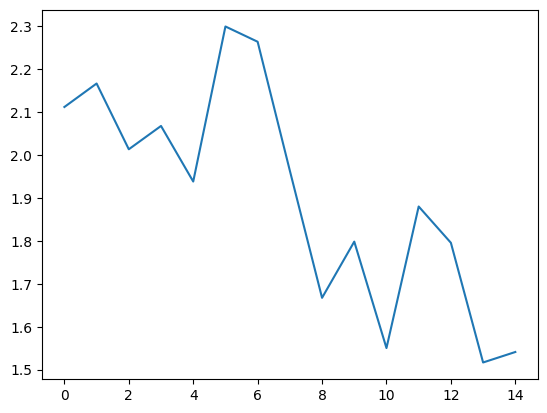

In [36]:
plt.plot(history.history['loss'])

# save final model

In [37]:
model.save('vegetables_model_resnet_50.h5')

In [38]:
validation_dir = "./data/validation"
IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size = 32

validation_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=validation_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 3000 images belonging to 15 classes.


In [39]:
model.evaluate(validation_data_gen)

94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 578ms/step - categorical_accuracy: 0.1033 - loss: 36.8951


[37.26797103881836, 0.09333333373069763]

In [40]:
test_dir = "./data/test"
IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size = 32

test_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 3000 images belonging to 15 classes.


In [44]:
model.evaluate(test_data_gen)

94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 582ms/step - categorical_accuracy: 0.0869 - loss: 36.8198


[37.025230407714844, 0.0963333323597908]

# Display samples from validation set

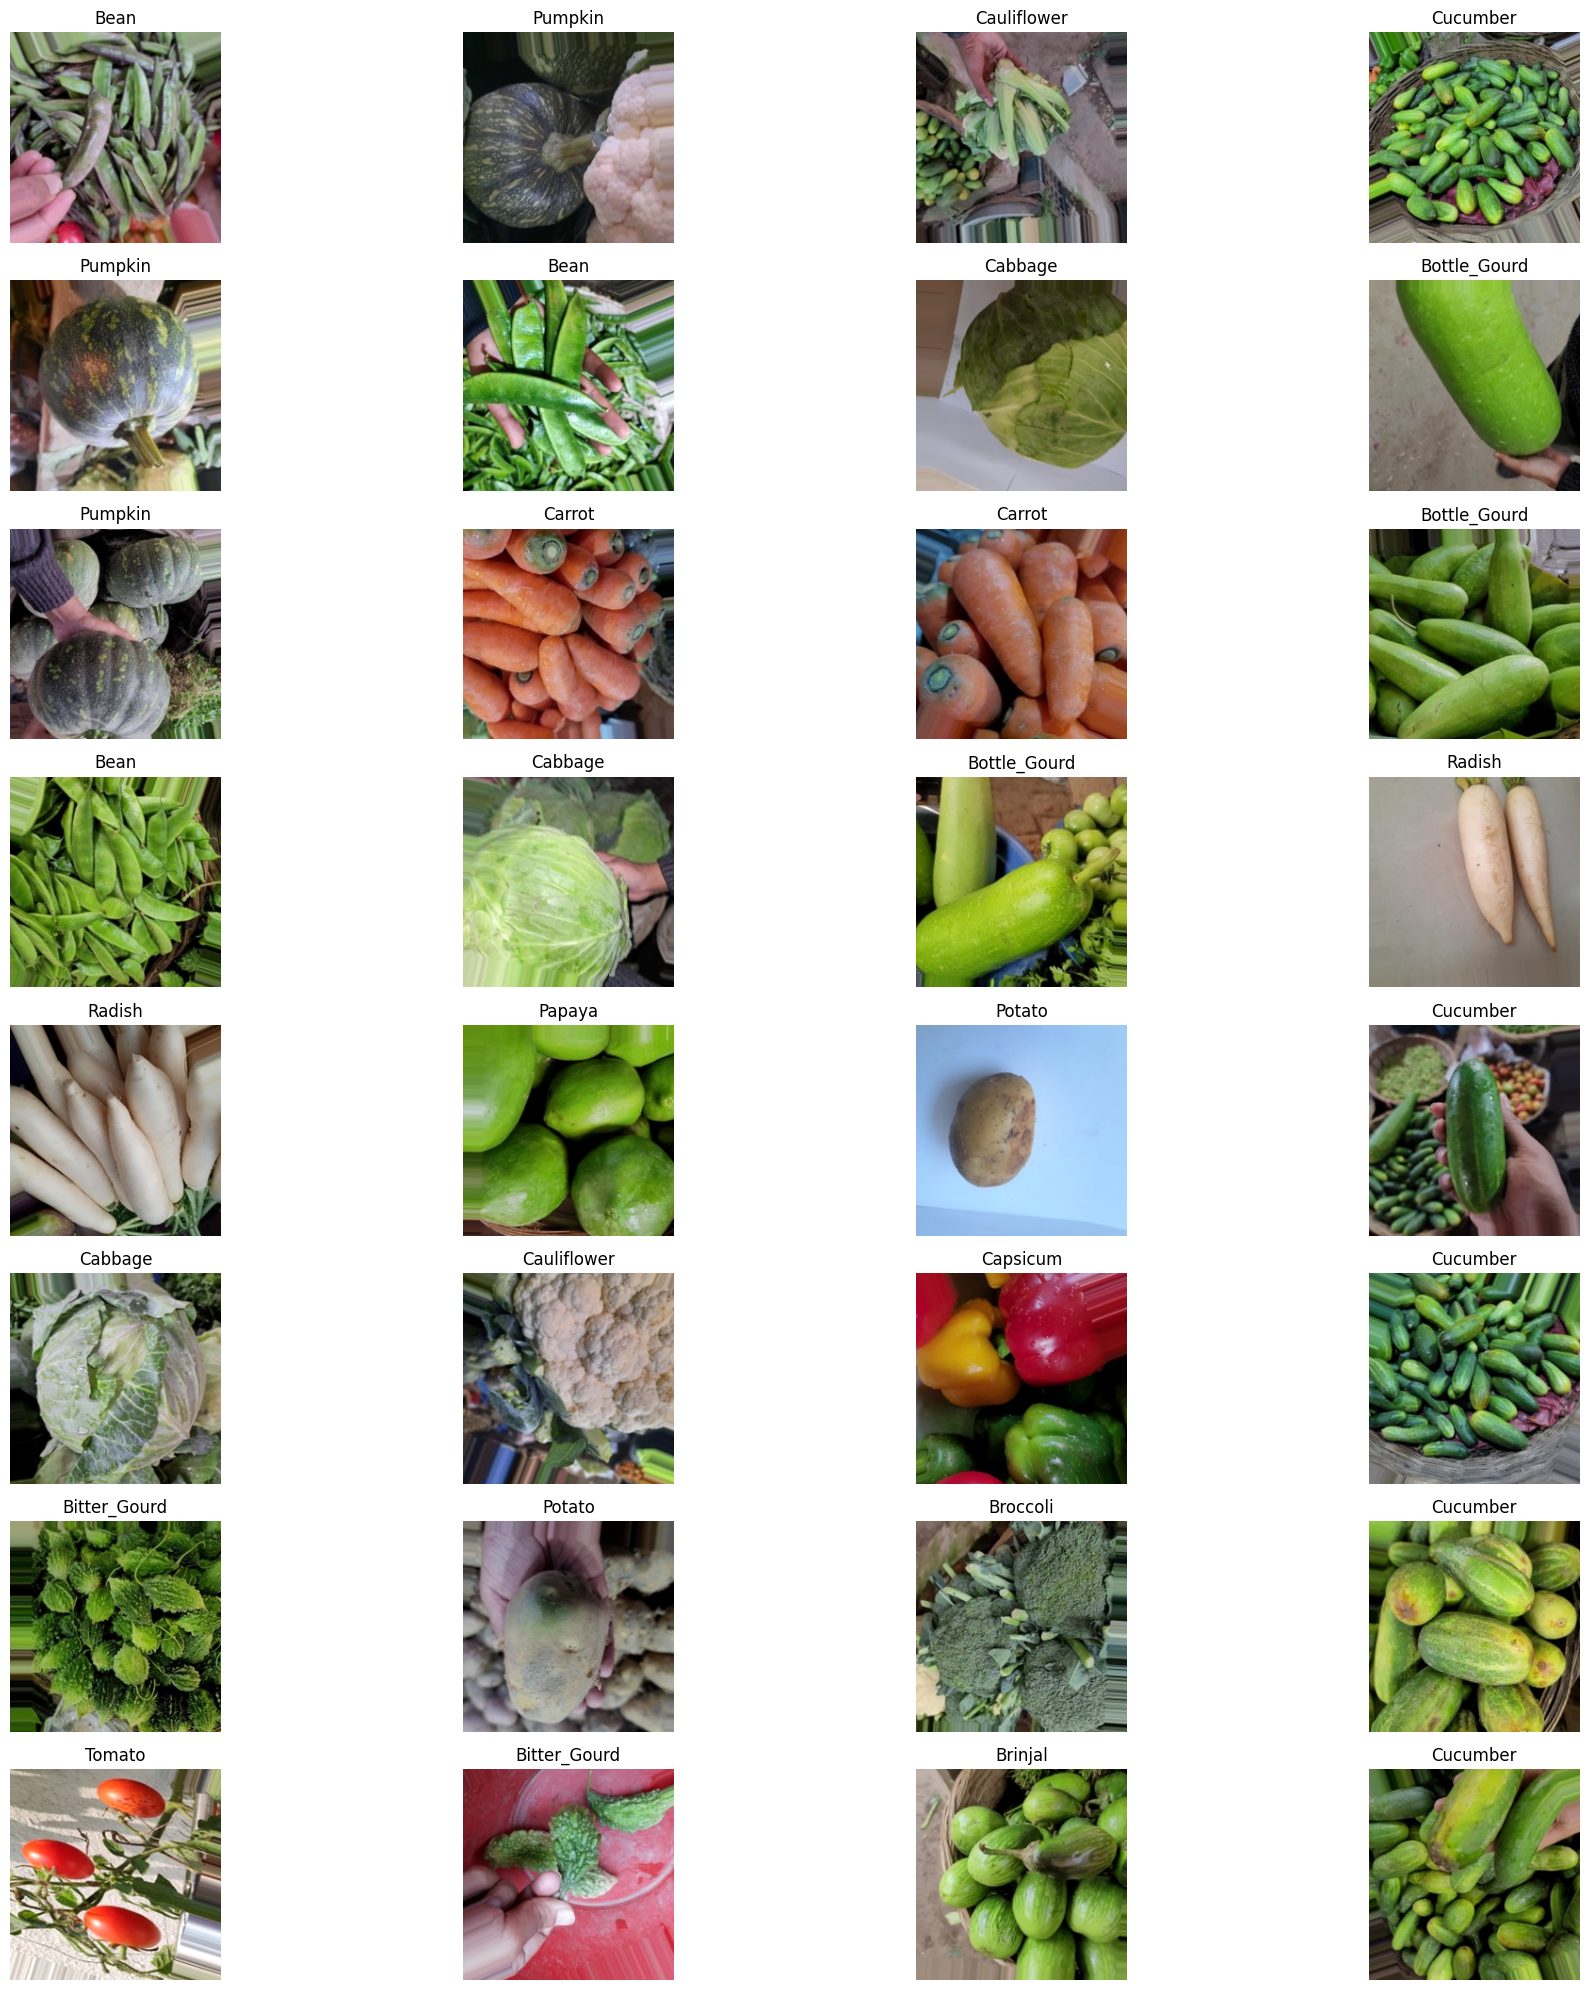

In [42]:
sample_validation_images, labels = next(test_data_gen)
class_label = {v:k for k,v in test_data_gen.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_validation_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()